# **1.** **CLEANING & PREPARING THE DATASET:**

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
link = "https://raw.githubusercontent.com/yagmurtomruk/yagmurtomruk/main/DSA210_DATA.xlsx"
df = pd.read_excel(link)

# Dealing with the dates:
df['Date'] = pd.to_datetime(df['Date'])


Initially, the missing values should be handled correctly.
During my data collection period, there has been some days where I had to take rest days due to sickness or schedule, and some days where the data was not succesfully obtained from the smartwatch. So, these missing values had to be detected and filled with the mean value for correction:

In [11]:
# Cleaning the data:
# Fill missing values with the mean
print("Missing values:")
print(df.isnull().sum())
df.fillna(df.mean(), inplace=True)


Missing values:
Date                     0
Temperature              0
Humidity                 0
AQI                      0
PM2.5 conc.              0
NO2 conc                 0
Running Distance (km)    3
Pace (min/km)            4
Heart Rate (BPM)         4
dtype: int64


In [12]:
# Categorizing the AQI values:

def categorize_aqi(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 150:
        return "Unhealthy for Sensitive Groups"
    else:
        return "Unhealthy"

df["AQI_Category"] = df["AQI"].apply(categorize_aqi)

# **2.** **DATA SUMMARY:**

In [14]:
# Extracting basic information on the dataset:

print("Data Information:")
df.info()

# Descriptive statistics

print("\nDescriptive Statistics:")
display(df.describe())


Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   45 non-null     datetime64[ns]
 1   Temperature            45 non-null     float64       
 2   Humidity               45 non-null     float64       
 3   AQI                    45 non-null     int64         
 4   PM2.5 conc.            45 non-null     float64       
 5   NO2 conc               45 non-null     float64       
 6   Running Distance (km)  45 non-null     float64       
 7   Pace (min/km)          45 non-null     float64       
 8   Heart Rate (BPM)       45 non-null     float64       
 9   AQI_Category           45 non-null     object        
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 3.6+ KB

Descriptive Statistics:


,Date,Temperature,Humidity,AQI,PM2.5 conc.,NO2 conc,Running Distance (km),Pace (min/km),Heart Rate (BPM)
count,45,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,2025-04-01 00:00:00,11.871111,74.762222,92.155556,24.722222,31.902222,4.601905,5.731707,151.512195
min,2025-03-10 00:00:00,8.100000,64.100000,49.000000,11.100000,20.800000,3.000000,5.000000,138.000000
25%,2025-03-21 00:00:00,10.600000,71.000000,72.000000,21.700000,29.500000,4.200000,5.500000,149.000000
50%,2025-04-01 00:00:00,12.000000,74.000000,83.000000,24.200000,32.000000,4.600000,5.731707,151.512195
75%,2025-04-12 00:00:00,13.300000,78.000000,104.000000,27.500000,34.900000,5.200000,6.000000,157.000000
max,2025-04-23 00:00:00,15.200000,84.900000,167.000000,37.000000,39.000000,6.100000,6.500000,163.000000
std,NaN,1.830626,4.899642,32.562496,6.241244,4.028731,0.639287,0.360832,6.026917


# **3.** **EDA/VISUALIZATION:**

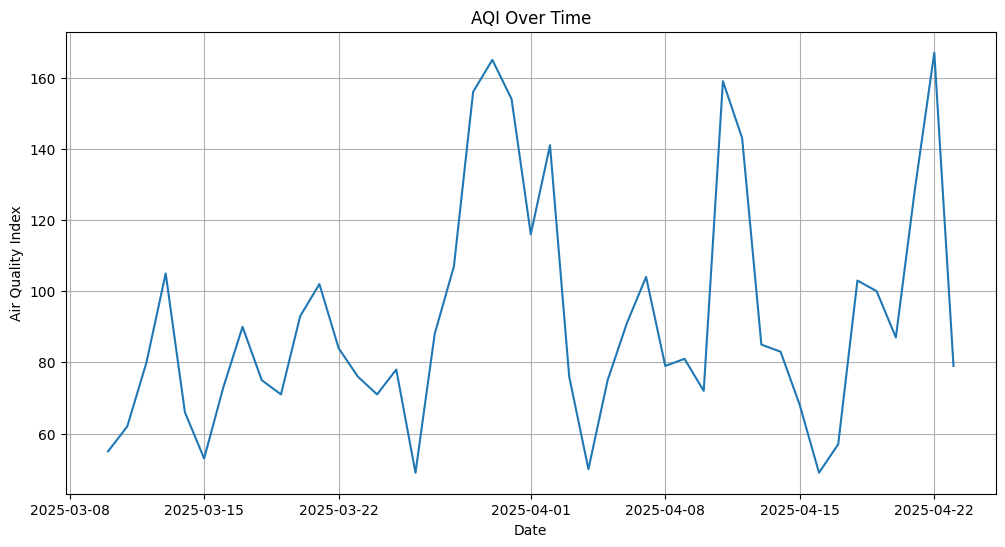

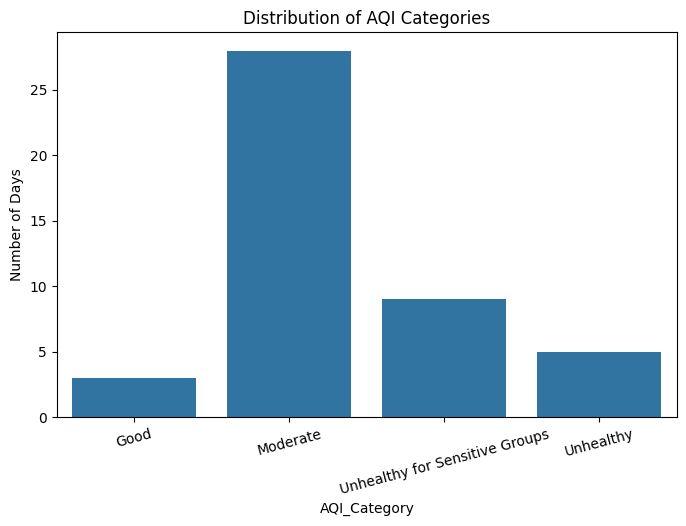

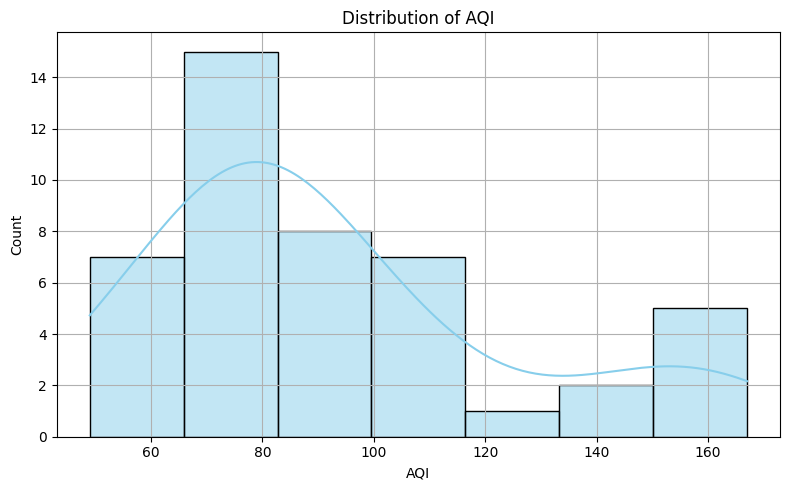

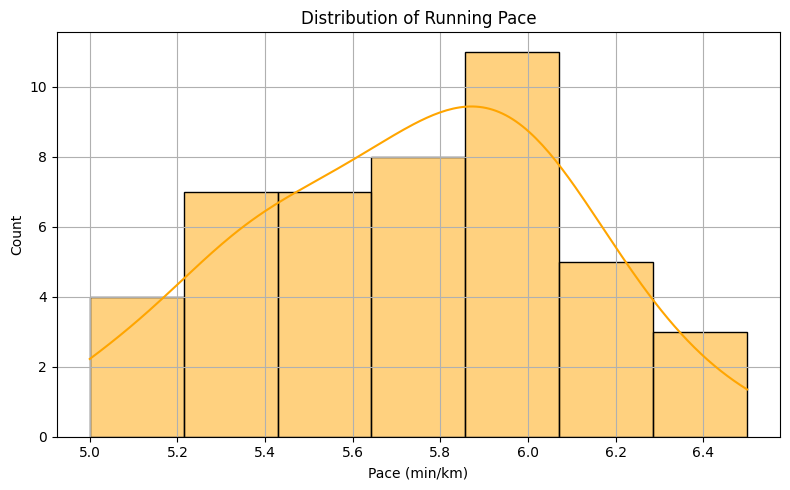

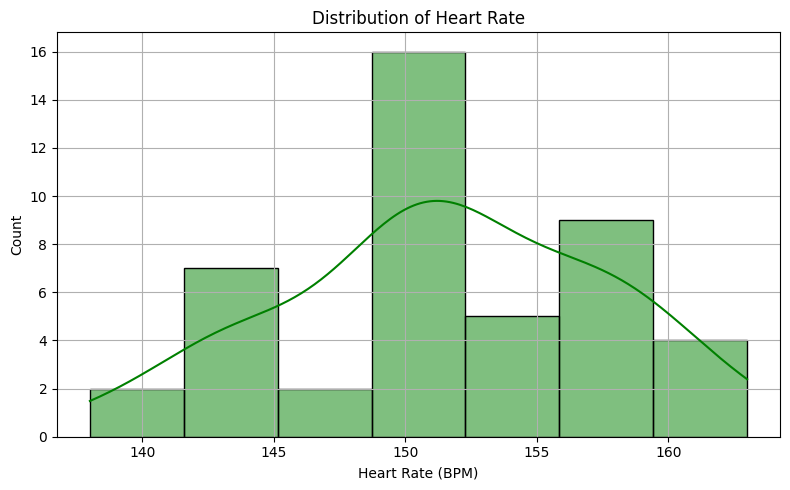

In [15]:
# Visualizations

# How AQI changes over time:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Date", y="AQI")
plt.title("AQI Over Time")
plt.xlabel("Date")
plt.ylabel("Air Quality Index")
plt.grid(True)
plt.show()

# AQI categories by date:
plt.figure(figsize=(8, 5))
sns.countplot(x="AQI_Category", data=df, order=["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy"])
plt.title("Distribution of AQI Categories")
plt.ylabel("Number of Days")
plt.xticks(rotation=15)
plt.show()

# Distribution of some of the important attributes:

dist_plots = {"AQI": ("Distribution of AQI", "skyblue"),"Pace (min/km)": ("Distribution of Running Pace", "orange"),"Heart Rate (BPM)": ("Distribution of Heart Rate", "green")}

# Plotting the distributions:
for var, (title, color) in dist_plots.items():
    plt.figure(figsize=(8, 5))
    sns.histplot(df[var], kde=True, color=color)
    plt.title(title)
    plt.xlabel(var)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

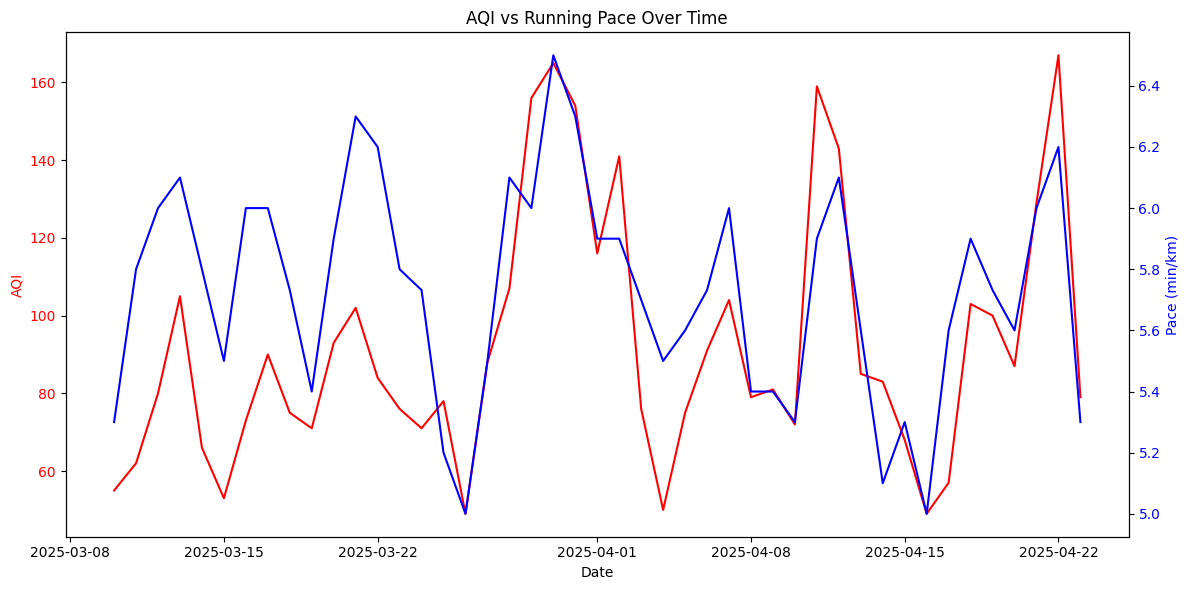

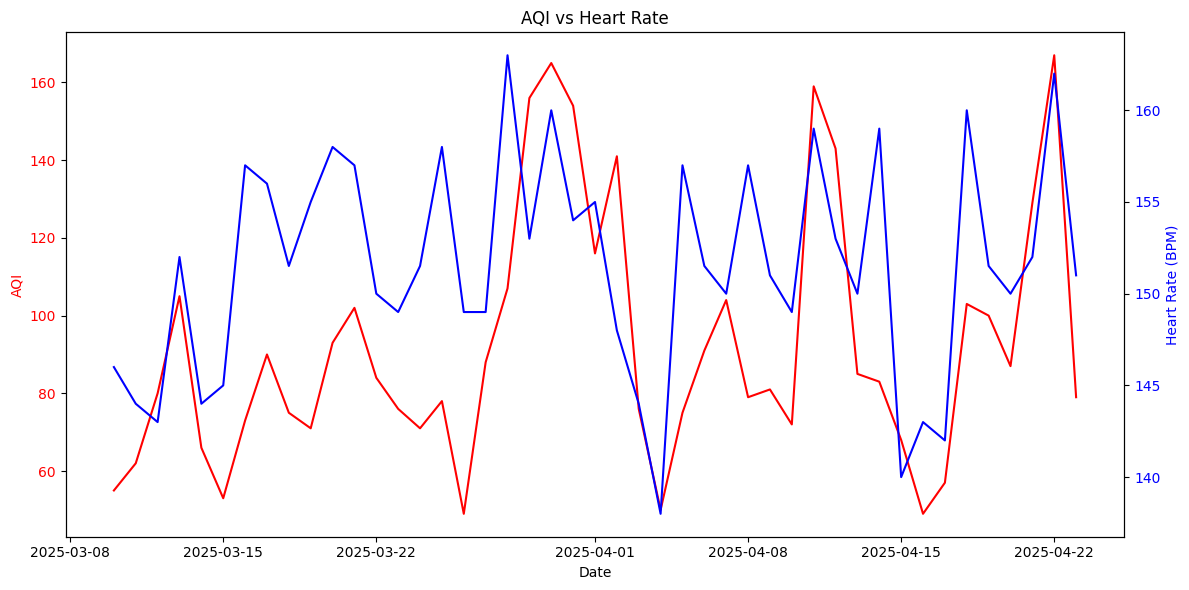

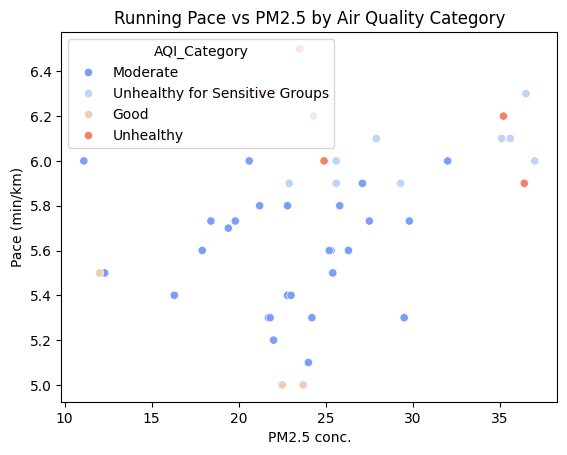

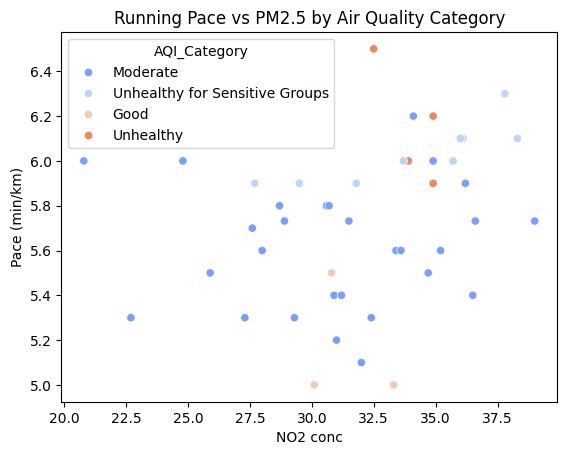

In [16]:
# AQI vs Pace:

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('AQI', color='red')
ax1.plot(df['Date'], df['AQI'], color='red', label='AQI')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Pace (min/km)', color='blue')
ax2.plot(df['Date'], df['Pace (min/km)'], color='blue', label='Pace')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('AQI vs Running Pace Over Time')
fig.tight_layout()
plt.show()

# AQI vs Heart Rate:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('AQI', color='red')
ax1.plot(df['Date'], df['AQI'], color='red', label='AQI')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Heart Rate (BPM)', color='blue')
ax2.plot(df['Date'], df['Heart Rate (BPM)'], color='blue', label='Pace')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('AQI vs Heart Rate')
fig.tight_layout()
plt.show()

# PM2.5 vs Pace:

sns.scatterplot(data=df, x="PM2.5 conc.", y="Pace (min/km)", hue="AQI_Category", palette="coolwarm")
plt.title("Running Pace vs PM2.5 by Air Quality Category")
plt.show()

# NO2 vs Pace:

sns.scatterplot(data=df, x="NO2 conc", y="Pace (min/km)", hue="AQI_Category", palette="coolwarm")
plt.title("Running Pace vs PM2.5 by Air Quality Category")
plt.show()


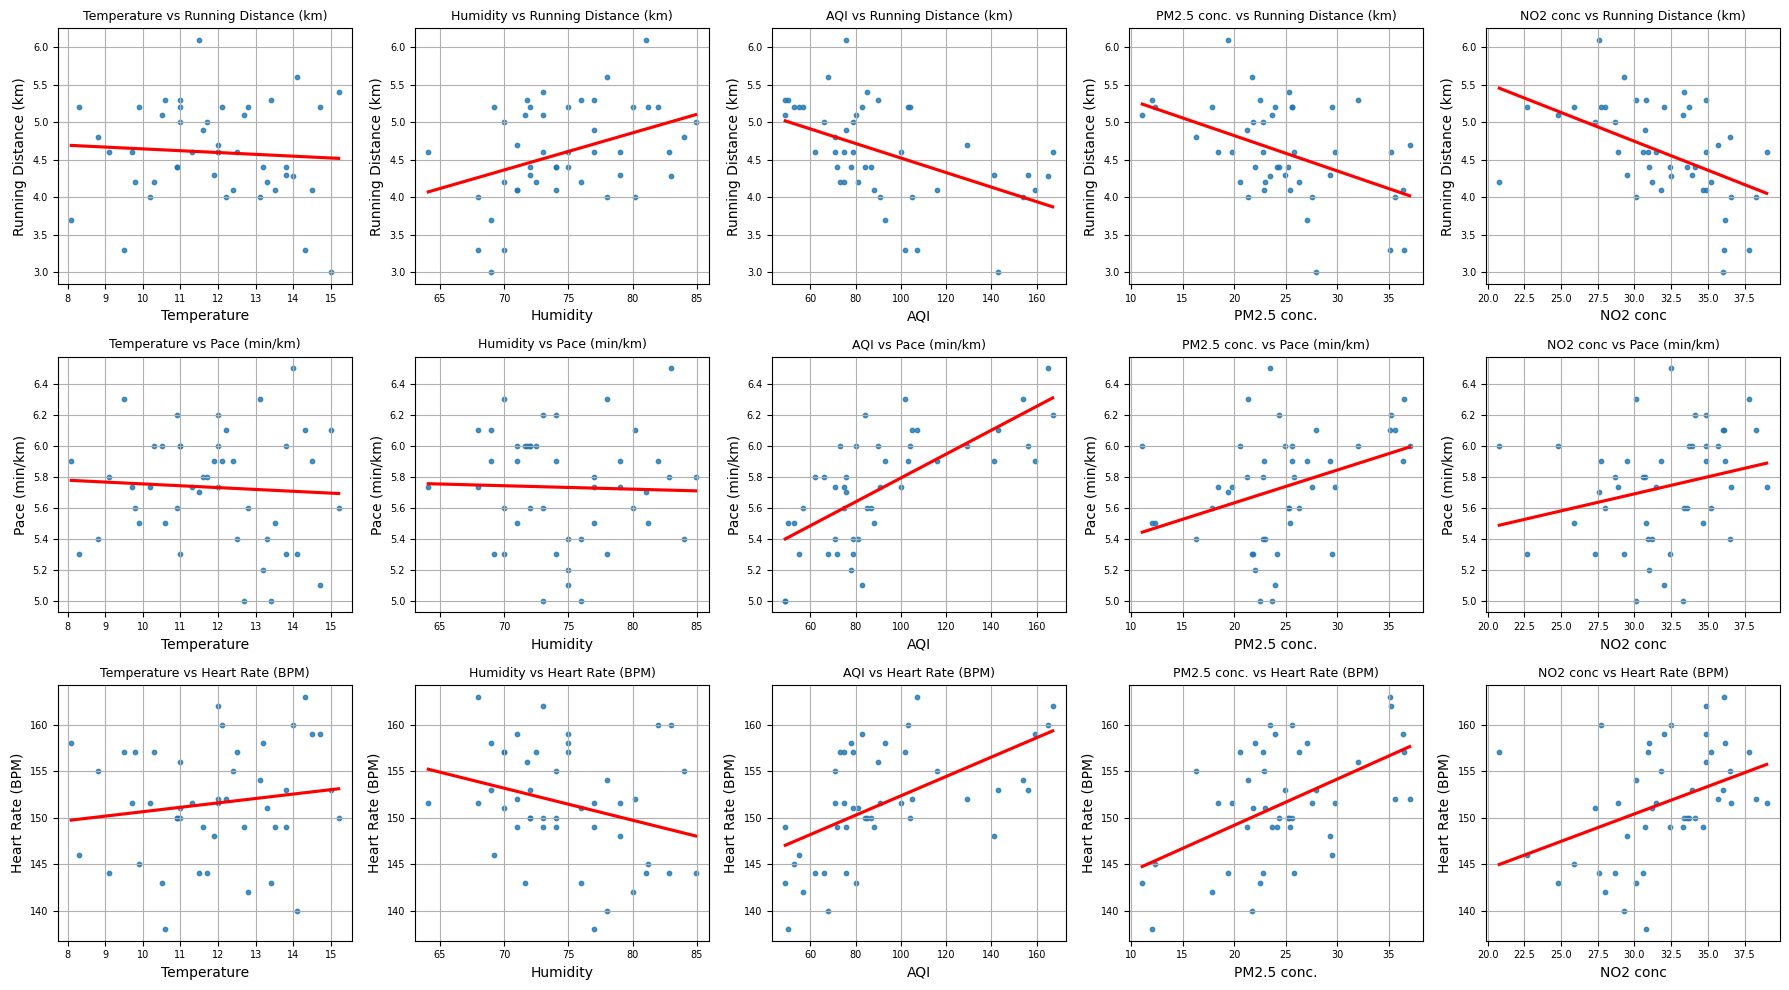

In [30]:
# Seeing how each of the performance attributes relate to each of the air quality indicators:
x_vars = ["Temperature", "Humidity", "AQI", "PM2.5 conc.", "NO2 conc"]
y_vars = ["Running Distance (km)", "Pace (min/km)", "Heart Rate (BPM)"]

# Set up the grid
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 10))
axes = axes.flatten()

# Plotting all combinations
plot_idx = 0
for y in y_vars:
    for x in x_vars:
        ax = axes[plot_idx]
        sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws={'s': 10}, line_kws={'color': 'red'}, ci=None)
        ax.set_title(f"{x} vs {y}", fontsize=9)
        ax.tick_params(axis='both', labelsize=7)
        ax.grid(True)
        plot_idx += 1

plt.tight_layout()
plt.show()

# **4.** **CORRELATION ANALYSIS:**

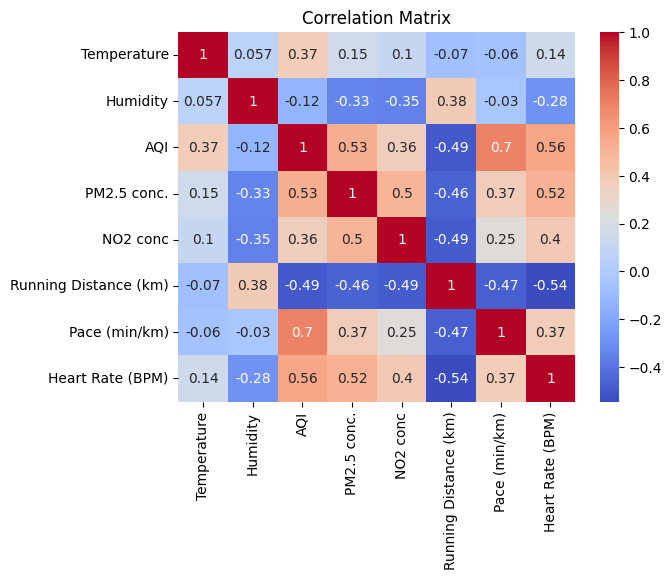

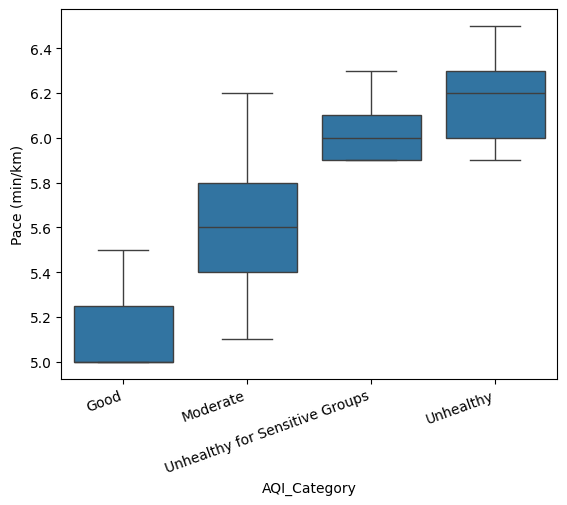

In [19]:
# Correlation heatmap
# Selecting numeric columns for correlation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Plot correlation heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Box plot to compare the paces for different AQI quality groups
order = ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy"]
sns.boxplot(x="AQI_Category", y="Pace (min/km)", data=df, order=order)
plt.xticks(rotation=20, ha='right');


# **5.** **HYPOTHESIS TESTING:**

**Hypothesis:**
Running pace is slower on days with poor air quality (high AQI values) compared to days with good air quality.

**Null Hypothesis (H₀):**
AQI has no significant effect on my pace.

**Alternative Hypothesis (H₁):**
The mean running pace is slower on unhealthy air quality days compared to good air quality days.



In [20]:
# ANOVA:
from scipy.stats import f_oneway
df["AQI_Category"] = df["AQI"].apply(categorize_aqi)

# Creating a list of pace values grouped by AQI category:
groups = [df[df["AQI_Category"] == cat]["Pace (min/km)"].dropna()
          for cat in ["Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy"]]

# Running one-way ANOVA:
f_stat, p_value = f_oneway(*groups)

print("F-Statistic:", f_stat)
print("P-Value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between pace and AQI.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between pace and AQI.")

F-Statistic: 16.826765923639844
P-Value: 2.817661563670174e-07
Reject the null hypothesis. There is a significant difference between pace and AQI.


So, the ANOVA test suggest that **the null hypothesis should be rejected.**

# **6.** **INSIGHTS:**

* **Running pace tends to be slower on days with worse air quality.** Especially on days when AQI was high, my average pace increased, which suggests I might be running more slowly in polluted conditions. This supports my original hypothesis.

* **Heart rate also seems to go up slightly when AQI, PM2.5, or temperature increases.** This could mean that my body is working harder when the air isn’t as clean or when it’s hotter outside.

* Running distance doesn’t change as dramatically, but **on some high-AQI or very hot days, I ran shorter distances**. This might be because I stopped earlier due to breathing discomfort or lower energy.

* The **ANOVA test** showed that there is a statistically significant difference in my pace between different AQI categories, which means the variation I saw in the plots is not just by chance